# Step F7D: Sample profit calculation

## 1. Import required libraries

In [1]:
import pandas as pd
import pickle
from datetime import datetime
import re
import numpy as np
import math
import os
import dataframe_image as df_img
from pandas import ExcelWriter 

In [2]:
pd.options.display.float_format = "{:,.2f}".format

## 2. Read all the saved prediction files

In [3]:
rex = re.compile('.*predictions_BERTModel..csv')

path = r'C:\\Users\\Karthik\\Desktop\\Dissertation\\Plots and metrics\\Results\\'

pred_files =  [i for i in os.listdir(path) if os.path.isfile(os.path.join(path,i)) and re.match(rex,i)]
pred_files

['AMC_combined_predictions_BERTModel1.csv',
 'AMC_combined_predictions_BERTModel2.csv',
 'AMC_combined_predictions_BERTModel3.csv',
 'AMC_combined_predictions_BERTModel4.csv',
 'AMC_reddit_predictions_BERTModel1.csv',
 'AMC_reddit_predictions_BERTModel2.csv',
 'AMC_reddit_predictions_BERTModel3.csv',
 'AMC_reddit_predictions_BERTModel4.csv',
 'AMC_twitter_predictions_BERTModel1.csv',
 'AMC_twitter_predictions_BERTModel2.csv',
 'AMC_twitter_predictions_BERTModel3.csv',
 'AMC_twitter_predictions_BERTModel4.csv',
 'AMD_combined_predictions_BERTModel1.csv',
 'AMD_combined_predictions_BERTModel2.csv',
 'AMD_combined_predictions_BERTModel3.csv',
 'AMD_combined_predictions_BERTModel4.csv',
 'AMD_reddit_predictions_BERTModel1.csv',
 'AMD_reddit_predictions_BERTModel2.csv',
 'AMD_reddit_predictions_BERTModel3.csv',
 'AMD_reddit_predictions_BERTModel4.csv',
 'AMD_twitter_predictions_BERTModel1.csv',
 'AMD_twitter_predictions_BERTModel2.csv',
 'AMD_twitter_predictions_BERTModel3.csv',
 'AMD_twitt

In [4]:
predictions = pd.concat([pd.read_csv(f'{path}{f}') for f in pred_files], axis=0)
predictions['Date'] = pd.to_datetime(predictions['Date'], dayfirst=True)
predictions

,Date,true_close,pred_close,model,platform,ticker
0,2020-08-28,6.30,5.86,BERT Model 1,combined,AMC
1,2020-09-02,7.04,5.58,BERT Model 1,combined,AMC
2,2020-09-04,7.02,5.72,BERT Model 1,combined,AMC
3,2020-09-16,5.76,5.72,BERT Model 1,combined,AMC
4,2020-10-09,4.05,4.00,BERT Model 1,combined,AMC
...,...,...,...,...,...,...
197,2021-07-26,599.36,659.19,BERT Model 4,twitter,TSLA
198,2021-07-27,604.87,632.89,BERT Model 4,twitter,TSLA
199,2021-07-28,616.60,623.66,BERT Model 4,twitter,TSLA
200,2021-07-29,623.31,633.92,BERT Model 4,twitter,TSLA


## 3. Calculte the profit for assumed scenarios

### 3.1 *Assumed scenario 1:*
- *if the predicted stock price for day n+1 is higher than real stock price at day n, then it is assumed that 100 units of currency will be invested at the start of next day (n+1) and sold at the end of day n+1*
- *if the predicted stock price for day n+1 is less than real stock price at day n, then it is assumed that the stock worth 100 units of currency will be short sold at the start of next day (n+1) and bought back at the end of day n+1 to close the shorting move*

In [5]:
tickers = predictions.ticker.unique().tolist()
models = predictions.model.unique().tolist()
platforms = predictions.platform.unique().tolist()

In [6]:
print(tickers)
print(models)
print(platforms)

['AMC', 'AMD', 'BABA', 'DKNG', 'TSLA']
['BERT Model 1', 'BERT Model 2', 'BERT Model 3', 'BERT Model 4']
['combined', 'reddit', 'twitter']


In [8]:
sc1_data_df = {}
consolidated_list = []
cumulative_list = []

for ticker in tickers:
    if ticker not in sc1_data_df:
        sc1_data_df[ticker]={}
        
    for model in models:
        if model not in sc1_data_df[ticker]:
            sc1_data_df[ticker][model]={}
        
        for platform in platforms:
#             print(ticker, model, platform)
            temp_df = predictions[(predictions['ticker']==ticker)&(predictions['model']==model)&(predictions['platform']==platform)].reset_index(drop=True)
#             print(temp_df)
            temp_df['pred_diff'] = temp_df['true_close'] - temp_df['pred_close']
            temp_df['pred_close+t'] = temp_df['pred_close']
            temp_df['pred_close+t'] = temp_df['pred_close+t'].shift(-1)
            temp_df['true_close-t'] = temp_df['true_close'].rolling(min_periods=2, window=2).apply(lambda x: x.iloc[0])
            temp_df['true_return'] = (temp_df['true_close']-temp_df['true_close-t'])/temp_df['true_close-t']
#             print(temp_df)
            temp_df['move'] = temp_df.apply(lambda x: 'buy' if x['pred_close+t']-x['true_close']>0 else 'sell', axis=1)
#             print(temp_df)
            temp_df['move-t'] = temp_df['move']
            temp_df['move-t'] = temp_df['move-t'].shift(1)
            temp_df = temp_df[['Date',
                        'model',
                        'platform',
                        'ticker',
                        'pred_diff',
                        'true_close',
                        'true_close-t',
                        'true_return',
                        'pred_close',
                        'pred_close+t',
                        'move',
                        'move-t'
                        ]]
            
            temp_df['profit_on_100'] = 0
            for i in range(0, len(temp_df)):
                if (temp_df.loc[i, 'move-t'] == 'buy'):
                    
                    cost_price = temp_df.loc[i, 'true_close-t']
                    no_of_shares = 100/cost_price
                    sell_price = temp_df.loc[i, 'true_close']
                    profit = round((sell_price-cost_price)*no_of_shares, 2)
                    temp_df.loc[i, 'profit_on_100'] = profit
                
                elif (temp_df.loc[i, 'move-t'] == 'sell'):
                    
                    sell_price = temp_df.loc[i, 'true_close-t']
                    no_of_shares = 100/sell_price
                    cost_price = temp_df.loc[i, 'true_close']
                    profit = round((sell_price-cost_price)*no_of_shares, 2)
                    temp_df.loc[i, 'profit_on_100'] = profit               
            
            temp_df['profit_on_100'] = temp_df['profit_on_100'].apply(lambda x: round(x,2))
            temp_df['cumulative_sum']= temp_df['profit_on_100'].cumsum()
                        
            sc1_data_df[ticker][model][platform] = temp_df
            
            consolidated_list.append([ticker, model, platform, temp_df.query(f'platform == "{platform}"')['profit_on_100'].sum()])
        
            for i in temp_df[['Date','model','platform','ticker','true_close','true_close-t','true_return','pred_close','pred_close+t','move','move-t','profit_on_100','pred_diff']].values.tolist():
                cumulative_list.append(i)                


results_df = pd.DataFrame(consolidated_list, columns=['ticker','model', 'platform','profit_on_100'])
stacked_df = results_df.pivot(index=['ticker','model'], columns='platform', values='profit_on_100')
# stacked_df['difference'] = stacked_df['reddit']-stacked_df['twitter']
stacked_df['Best_Return'] = stacked_df.idxmax(axis=1)
stacked_df['DIFF combined vs twitter'] = stacked_df['combined']-stacked_df['twitter']
stacked_df['PCT_DIFF combined vs twitter'] = ((stacked_df['combined']-stacked_df['twitter'])/stacked_df['combined'])*100
stacked_df['PCT_DIFF combined vs twitter'] = stacked_df['PCT_DIFF combined vs twitter'].apply(lambda x: float('%.2f'%(x)))

stacked_df = results_df.pivot(index=['ticker','model'], columns='platform', values='profit_on_100')
# stacked_df['difference'] = stacked_df['reddit']-stacked_df['twitter']
stacked_df['Best_Return'] = stacked_df.idxmax(axis=1)
stacked_df['DIFF combined vs twitter'] = stacked_df['combined']-stacked_df['twitter']
stacked_df['PCT_DIFF combined vs twitter'] = ((stacked_df['combined']-stacked_df['twitter'])/stacked_df['combined'])*100
stacked_df['PCT_DIFF combined vs twitter'] = stacked_df['PCT_DIFF combined vs twitter'].apply(lambda x: float('%.2f'%(x)))

stacked_df_styled = stacked_df.style.set_properties(**{ 'color': 'black !important',
                                                        'border': '1px black solid !important'
                                                        }).set_table_styles([{
                                                                              'selector': 'th',
                                                                              'props': [('border', '1px black solid !important')]
                                                                            }]).format({
                                                                                        'A': '{:,.2f}'.format,
                                                                                        'B': '{:,.2%}'.format,
                                                                                        })
display(stacked_df_styled)
df_img.export(stacked_df_styled, r'C:\\Users\\Karthik\\Desktop\\Dissertation\\Plots and metrics\\Sample_profit_calculation_Scenario1_complete.png')


stacked_df_mean = stacked_df.groupby(['model'],as_index=True).agg({'combined':'mean','reddit':'mean','twitter':'mean'})
stacked_df_sum = stacked_df.groupby(['model'],as_index=True).agg({'combined':'sum','reddit':'sum','twitter':'sum'})

print("\n\nTotal Profit From Scenario 1")
display(stacked_df_sum)

print("\n\nAverage Profit From Scenario 1")
display(stacked_df_mean)

cumulative_df = pd.DataFrame(cumulative_list, columns=['Date','model','platform','ticker','true_close','true_close-t','true_return','pred_close','pred_close+t','move','move-t','profit_on_100','pred_diff'])
# cumulative_df['Date']= pd.to_datetime(cumulative_df['Date'])
cumulative_df = cumulative_df.groupby(['model','platform', 'Date'],as_index=False).agg({'profit_on_100':'sum', 'pred_diff':'sum'})
cumulative_df['cumu_sum'] = cumulative_df.groupby(['model', 'platform'])['profit_on_100'].cumsum()
print("\n\nCumulative Profit From Scenario 1")
display(cumulative_df)

path = 'C:\\Users\\Karthik\\Desktop\\Dissertation\\Plots and metrics\\Tables\\'
xl_writer = ExcelWriter(f'{path}Scenario_1.xlsx')
stacked_df_styled.to_excel(xl_writer, sheet_name='Detailed')
stacked_df_sum.to_excel(xl_writer, sheet_name='Sum_Profit')
stacked_df_mean.to_excel(xl_writer, sheet_name='Mean_Profit')
cumulative_df.to_excel(xl_writer, sheet_name='Cumulative_Profit')
xl_writer.save()                 
                



Total Profit From Scenario 1


,combined,reddit,twitter
model,,,
BERT Model 1,"1,726.36","1,557.48","1,588.34"
BERT Model 2,"2,000.70","1,641.84","1,539.00"
BERT Model 3,"1,658.04","1,540.44","1,977.16"
BERT Model 4,"1,661.58","2,134.68","1,757.42"




Average Profit From Scenario 1


,combined,reddit,twitter
model,,,
BERT Model 1,345.27,311.50,317.67
BERT Model 2,400.14,328.37,307.80
BERT Model 3,331.61,308.09,395.43
BERT Model 4,332.32,426.94,351.48




Cumulative Profit From Scenario 1


,model,platform,Date,profit_on_100,pred_diff,cumu_sum
0,BERT Model 1,combined,2020-08-13,0.00,2.13,0.00
1,BERT Model 1,combined,2020-08-14,1.83,-2.06,1.83
2,BERT Model 1,combined,2020-08-17,7.40,13.45,9.23
3,BERT Model 1,combined,2020-08-18,10.97,-0.13,20.20
4,BERT Model 1,combined,2020-08-19,-2.44,-17.10,17.76
...,...,...,...,...,...,...
2431,BERT Model 4,twitter,2021-07-26,-3.20,-54.39,"1,744.60"
2432,BERT Model 4,twitter,2021-07-27,6.82,-30.51,"1,751.42"
2433,BERT Model 4,twitter,2021-07-28,-1.07,36.00,"1,750.35"
2434,BERT Model 4,twitter,2021-07-29,3.44,35.05,"1,753.79"


C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\formats\excel.py:331: CSSWarning: Unhandled color format: 'black !important'
  warnings.warn(f"Unhandled color format: {repr(val)}", CSSWarning)


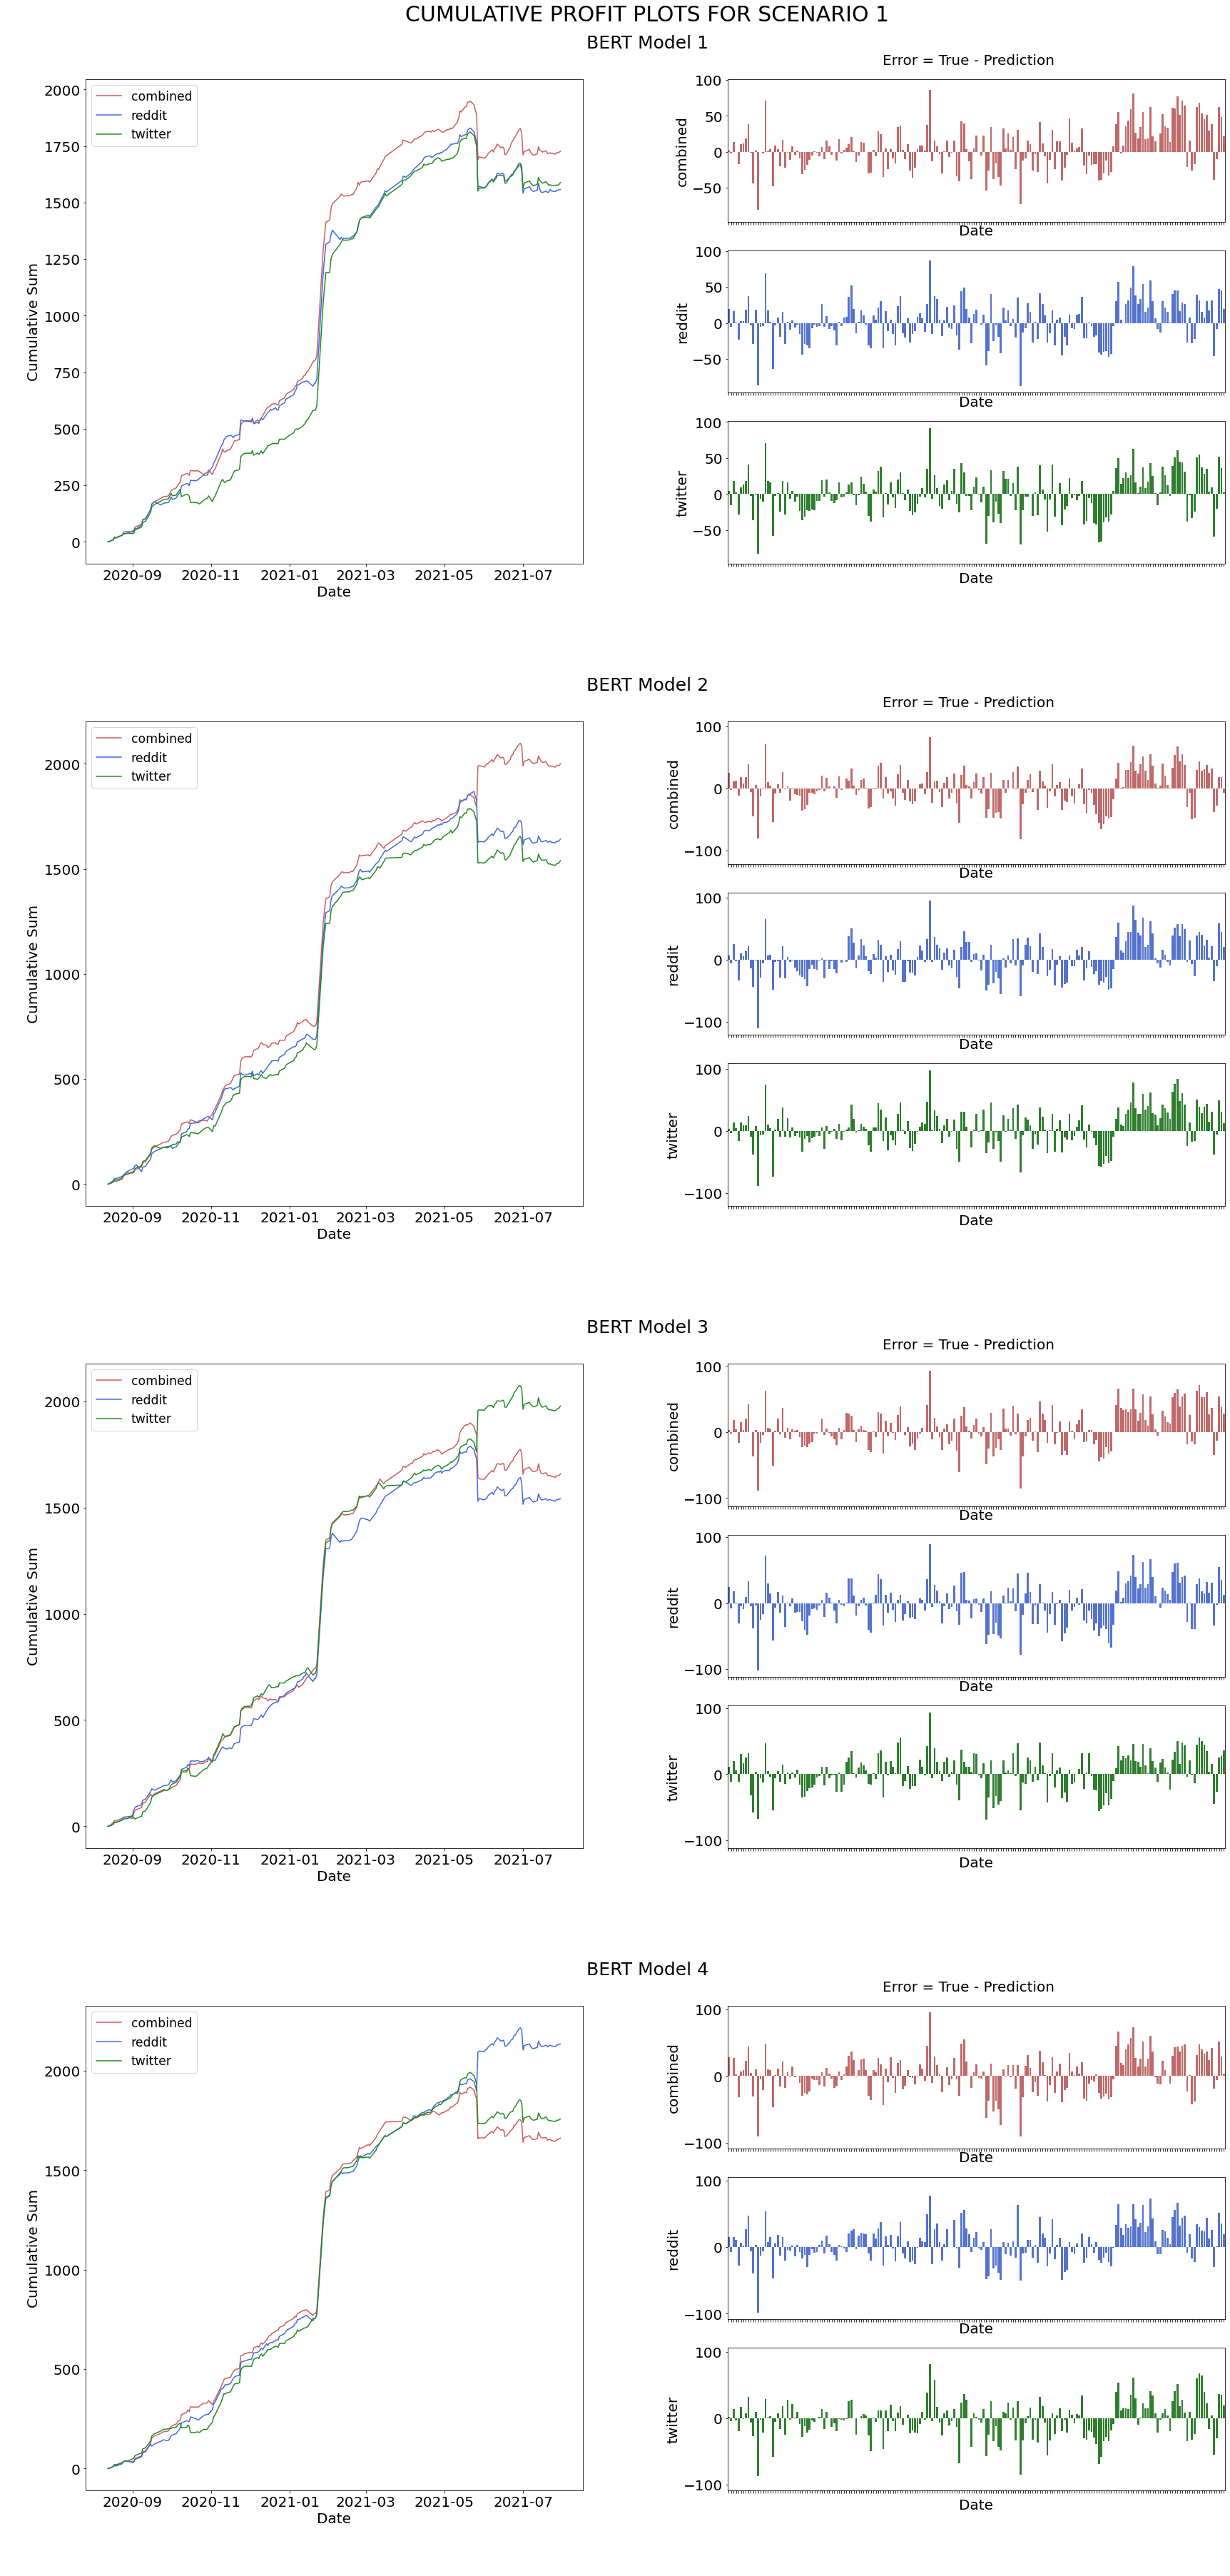

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

models=cumulative_df.model.unique().tolist()
platforms = cumulative_df.platform.unique().tolist()

fig = plt.figure(figsize=(25, 50))
subfigs = fig.subfigures(4, 1)
fig.suptitle('CUMULATIVE PROFIT PLOTS FOR SCENARIO 1', fontsize=30, fontweight=5, y=0.999)

for i in range(0, len(models)):
    subfigs_2=None
    axs_Left=None
    axs_Right=None
    
    subfigs[i].suptitle(f'{models[i]}', fontsize=25, fontweight=5, y=0.95)
    subfigs_2 = subfigs[i].subfigures(1,2, wspace=0.07)
    axs_Left = subfigs_2[0].subplots(1, 1, sharey=True)
    axs_Right = subfigs_2[1].subplots(3, 1, sharex=True, sharey=True)

#     for model in models:

    subfigs_2[1].suptitle("Error = True - Prediction", y=0.92, fontsize=20)
    for plt in platforms:
        color=None
        axi=None
        if plt == 'reddit':
            color='royalblue'
            axi=1
        elif plt=='twitter':
            color='forestgreen'
            axi=2
        else:
            color='indianred'
            axi=0

        data = cumulative_df.query(f'model == "{models[i]}" & platform == "{plt}"')
        sns.lineplot(data=data,x="Date", y="cumu_sum", ax=axs_Left, color=color, label=plt)
        sns.barplot(data=data,x="Date", y="pred_diff", ax=axs_Right[axi], color=color, label=plt)
        axs_Left.legend(fontsize='xx-large', title_fontsize='40')
        axs_Left.tick_params(axis='both', which='major', labelsize=20)
        axs_Left.tick_params(axis='both', which='minor', labelsize=20)
        axs_Left.set_ylabel('Cumulative Sum', fontsize=20)
        axs_Left.set_xlabel('Date', fontsize=20)
        axs_Right[axi].set_ylabel(plt, fontsize=20)
        axs_Right[axi].set_xlabel('Date', fontsize=20)
        axs_Right[axi].xaxis.set_ticklabels([])
        axs_Right[axi].tick_params(axis='y', which='major', labelsize=20)

# fig.subplots_adjust(left=0.05, bottom=0.2, right=None, top=0.70, wspace=0.1, hspace=0.2)    
path = r'C:\\Users\\Karthik\\Desktop\\Dissertation\\Plots and metrics\\'    
fig.savefig(f'{path}\Cumulative_Profit_Plots - Scenario 1.jpg');

### 3.2. *Assumed scenario 2:*
- *if the predicted stock price for day n+1 is higher than real stock price at day n, then it is assumed that 100 units of currency will be invested at the start of next day (n+1) and sold at the end of day n+1*
- *if the predicted stock price for day n+1 is less than real stock price at day n, then no investment is made*
- *in other words this scenario assumes investments by a novice who only does LONG trades and does not involve in SHORT trades*

In [10]:
sc2_data_df = {}
consolidated_list = []
cumulative_list = []

for ticker in tickers:
    if ticker not in sc2_data_df:
        sc2_data_df[ticker]={}
        
    for model in models:
        if model not in sc2_data_df[ticker]:
            sc2_data_df[ticker][model]={}
        
        for platform in platforms:
#             display(ticker, model, platform)
            temp_df = predictions[(predictions['ticker']==ticker)&(predictions['model']==model)&(predictions['platform']==platform)].reset_index(drop=True)
#             display(temp_df)
            temp_df['pred_diff'] = temp_df['true_close'] - temp_df['pred_close']
            temp_df['pred_close+t'] = temp_df['pred_close']
            temp_df['pred_close+t'] = temp_df['pred_close+t'].shift(-1)
            temp_df['true_close-t'] = temp_df['true_close'].rolling(min_periods=2, window=2).apply(lambda x: x.iloc[0])
            temp_df['true_return'] = (temp_df['true_close']-temp_df['true_close-t'])/temp_df['true_close-t']
#             display(temp_df)
            temp_df['move'] = temp_df.apply(lambda x: 'buy' if x['pred_close+t']-x['true_close']>0 else 'sell', axis=1)
#             display(temp_df)
            temp_df['move-t'] = temp_df['move']
            temp_df['move-t'] = temp_df['move-t'].shift(1)
#             display(temp_df)
            temp_df = temp_df[['Date',
                        'model',
                        'platform',
                        'ticker',
                        'pred_diff',
                        'true_close',
                        'true_close-t',
                        'true_return',
                        'pred_close',
                        'pred_close+t',
                        'move',
                        'move-t']]

#             print(len(temp_df.query('`move-t` == "buy"')))
            temp_df['profit_on_100'] = 0
            for i in range(0, len(temp_df)):
                if (temp_df.loc[i, 'move-t'] == 'buy'):
                    cost_price = temp_df.loc[i, 'true_close-t']
                    no_of_shares = 100/cost_price
                    sell_price = temp_df.loc[i, 'true_close']
                    profit = round((sell_price-cost_price)*no_of_shares, 2)
                    temp_df.loc[i, 'profit_on_100'] = profit

            temp_df['profit_on_100'] = temp_df['profit_on_100'].apply(lambda x: round(x,2))
            temp_df['cumulative_sum']= temp_df['profit_on_100'].cumsum()
            
            sc2_data_df[ticker][model][platform] = temp_df
            
            consolidated_list.append([ticker, model, platform, temp_df.query(f'platform == "{platform}"')['profit_on_100'].sum()])

            for i in temp_df[['Date','model','platform','ticker','true_close','true_close-t','true_return','pred_close','pred_close+t','move','move-t','profit_on_100','pred_diff']].values.tolist():
                cumulative_list.append(i)   


results_df = pd.DataFrame(consolidated_list, columns=['ticker','model', 'platform','profit_on_100'])
stacked_df = results_df.pivot(index=['ticker','model'], columns='platform', values='profit_on_100')
# stacked_df['difference'] = stacked_df['reddit']-stacked_df['twitter']
stacked_df['Best_Return'] = stacked_df.idxmax(axis=1)
stacked_df['DIFF combined vs twitter'] = stacked_df['combined']-stacked_df['twitter']
stacked_df['PCT_DIFF combined vs twitter'] = ((stacked_df['combined']-stacked_df['twitter'])/stacked_df['combined'])*100
stacked_df['PCT_DIFF combined vs twitter'] = stacked_df['PCT_DIFF combined vs twitter'].apply(lambda x: float('%.2f'%(x)))

stacked_df_styled = stacked_df.style.set_properties(**{ 'color': 'black !important',
                                                        'border': '1px black solid !important'
                                                        }).set_table_styles([{
                                                                              'selector': 'th',
                                                                              'props': [('border', '1px black solid !important')]
                                                                            }]).format({
                                                                                        'A': '{:,.2f}'.format,
                                                                                        'B': '{:,.2%}'.format,
                                                                                        })
df_img.export(stacked_df_styled, r'C:\\Users\\Karthik\\Desktop\\Dissertation\\Plots and metrics\\Sample_profit_calculation_Scenario2_complete.png')
display(stacked_df_styled)

print("\n\nTotal Profit From Scenario 2")
display(stacked_df_sum)

print("\n\nAverage Profit From Scenario 2")
display(stacked_df_mean)

stacked_df_mean = stacked_df.groupby(['model'],as_index=True).agg({'combined':'mean','reddit':'mean','twitter':'mean'})
stacked_df_sum = stacked_df.groupby(['model'],as_index=True).agg({'combined':'sum','reddit':'sum','twitter':'sum'})


cumulative_df = pd.DataFrame(cumulative_list, columns=['Date','model','platform','ticker','true_close','true_close-t','true_return','pred_close','pred_close+t','move','move-t','profit_on_100','pred_diff'])
cumulative_df['Date']= pd.to_datetime(cumulative_df['Date'])
cumulative_df = cumulative_df.groupby(['model','platform', 'Date'],as_index=False).agg({'profit_on_100':'sum', 'pred_diff':'sum'})
cumulative_df['cumu_sum'] = cumulative_df.groupby(['model', 'platform'])['profit_on_100'].cumsum()
print("\n\nCumulative Profit From Scenario 2")
display(cumulative_df)


path = 'C:\\Users\\Karthik\\Desktop\\Dissertation\\Plots and metrics\\Tables\\'
xl_writer = ExcelWriter(f'{path}Scenario_2.xlsx')
stacked_df_styled.to_excel(xl_writer, sheet_name='Detailed')
stacked_df_sum.to_excel(xl_writer, sheet_name='Sum_Profit')
stacked_df_mean.to_excel(xl_writer, sheet_name='Mean_Profit')
cumulative_df.to_excel(xl_writer, sheet_name='Cumulative_Profit')
xl_writer.save() 



Total Profit From Scenario 2


,combined,reddit,twitter
model,,,
BERT Model 1,"1,726.36","1,557.48","1,588.34"
BERT Model 2,"2,000.70","1,641.84","1,539.00"
BERT Model 3,"1,658.04","1,540.44","1,977.16"
BERT Model 4,"1,661.58","2,134.68","1,757.42"




Average Profit From Scenario 2


,combined,reddit,twitter
model,,,
BERT Model 1,345.27,311.50,317.67
BERT Model 2,400.14,328.37,307.80
BERT Model 3,331.61,308.09,395.43
BERT Model 4,332.32,426.94,351.48




Cumulative Profit From Scenario 2


,model,platform,Date,profit_on_100,pred_diff,cumu_sum
0,BERT Model 1,combined,2020-08-13,0.00,2.13,0.00
1,BERT Model 1,combined,2020-08-14,1.83,-2.06,1.83
2,BERT Model 1,combined,2020-08-17,7.40,13.45,9.23
3,BERT Model 1,combined,2020-08-18,10.97,-0.13,20.20
4,BERT Model 1,combined,2020-08-19,-2.44,-17.10,17.76
...,...,...,...,...,...,...
2431,BERT Model 4,twitter,2021-07-26,-2.64,-54.39,"1,344.13"
2432,BERT Model 4,twitter,2021-07-27,0.34,-30.51,"1,344.47"
2433,BERT Model 4,twitter,2021-07-28,1.06,36.00,"1,345.53"
2434,BERT Model 4,twitter,2021-07-29,2.38,35.05,"1,347.91"


C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\formats\excel.py:331: CSSWarning: Unhandled color format: 'black !important'
  warnings.warn(f"Unhandled color format: {repr(val)}", CSSWarning)


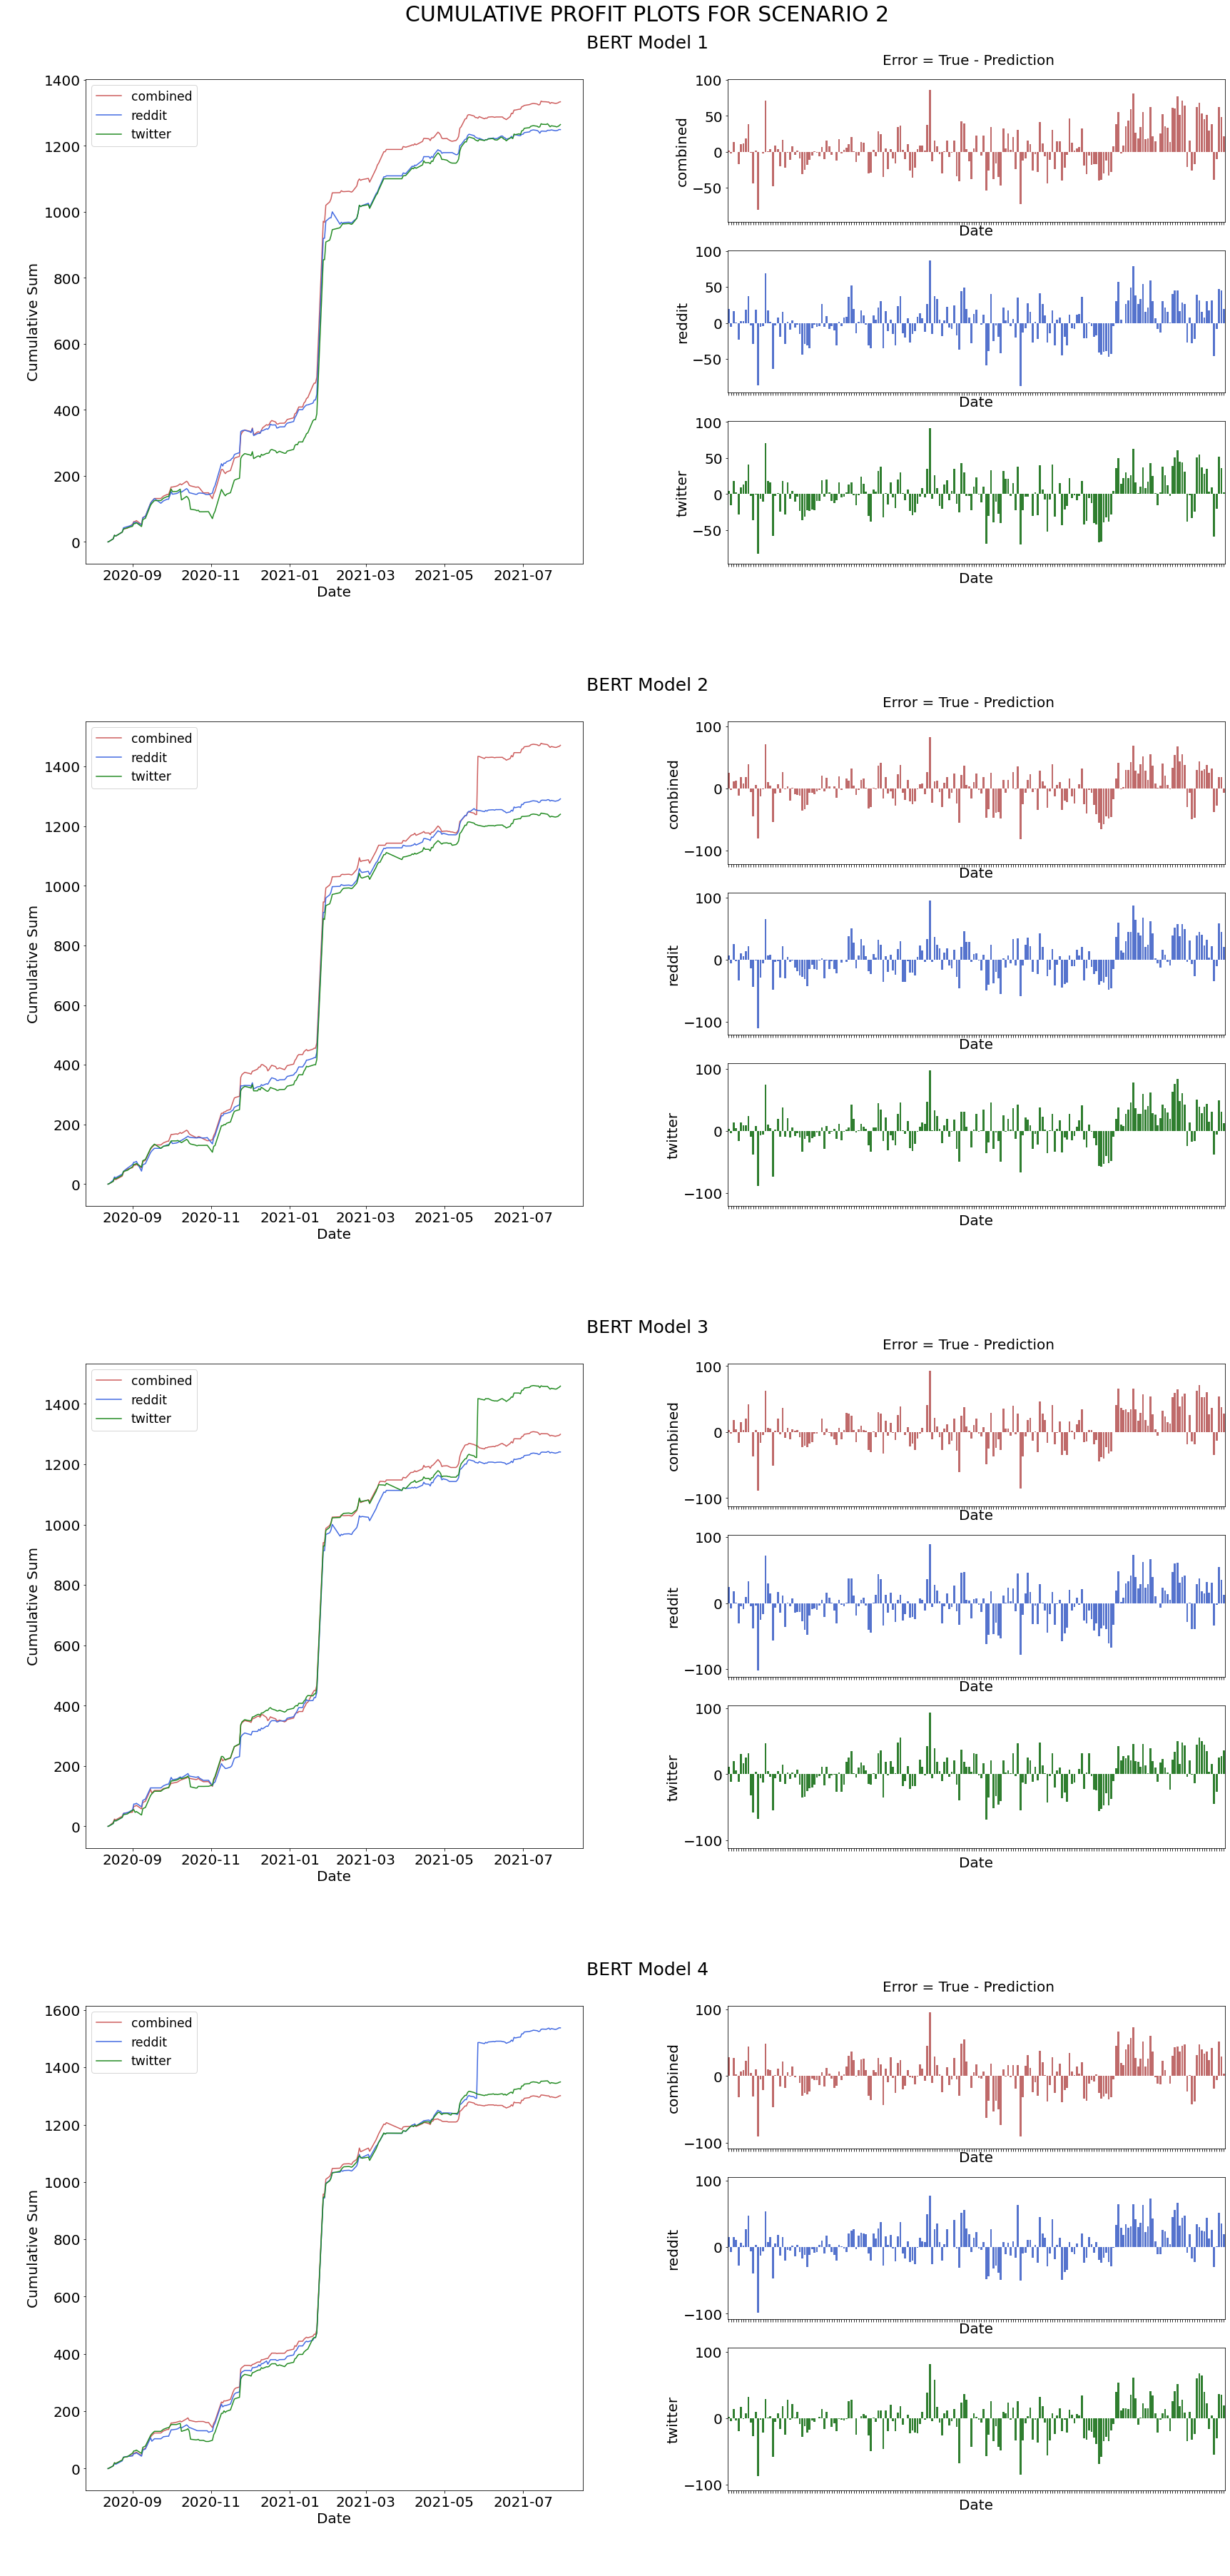

In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

models=cumulative_df.model.unique().tolist()
platforms = cumulative_df.platform.unique().tolist()

fig = plt.figure(figsize=(25, 50))
subfigs = fig.subfigures(4, 1)
fig.suptitle('CUMULATIVE PROFIT PLOTS FOR SCENARIO 2', fontsize=30, fontweight=5, y=0.999)

for i in range(0, len(models)):
    subfigs_2=None
    axs_Left=None
    axs_Right=None
    
    subfigs[i].suptitle(f'{models[i]}', fontsize=25, fontweight=5, y=0.95)
    subfigs_2 = subfigs[i].subfigures(1,2, wspace=0.07)
    axs_Left = subfigs_2[0].subplots(1, 1, sharey=True)
    axs_Right = subfigs_2[1].subplots(3, 1, sharex=True, sharey=True)

#     for model in models:

    subfigs_2[1].suptitle("Error = True - Prediction", y=0.92, fontsize=20)
    for plt in platforms:
        color=None
        axi=None
        if plt == 'reddit':
            color='royalblue'
            axi=1
        elif plt=='twitter':
            color='forestgreen'
            axi=2
        else:
            color='indianred'
            axi=0

        data = cumulative_df.query(f'model == "{models[i]}" & platform == "{plt}"')
        sns.lineplot(data=data,x="Date", y="cumu_sum", ax=axs_Left, color=color, label=plt)
        sns.barplot(data=data,x="Date", y="pred_diff", ax=axs_Right[axi], color=color, label=plt)
        axs_Left.legend(fontsize='xx-large', title_fontsize='40')
        axs_Left.tick_params(axis='both', which='major', labelsize=20)
        axs_Left.tick_params(axis='both', which='minor', labelsize=20)
        axs_Left.set_ylabel('Cumulative Sum', fontsize=20)
        axs_Left.set_xlabel('Date', fontsize=20)
        axs_Right[axi].set_ylabel(plt, fontsize=20)
        axs_Right[axi].set_xlabel('Date', fontsize=20)
        axs_Right[axi].xaxis.set_ticklabels([])
        axs_Right[axi].tick_params(axis='y', which='major', labelsize=20)
        
# fig.subplots_adjust(left=0.05, bottom=0.2, right=None, top=0.70, wspace=0.1, hspace=0.2)  
path = r'C:\\Users\\Karthik\\Desktop\\Dissertation\\Plots and metrics\\'    
fig.savefig(f'{path}\Cumulative_Profit_Plots - Scenario 2.jpg');